In [1]:
from bs4 import BeautifulSoup
import os

In [4]:
MIN_PARA_SIZE = 80

loss_keywords = ["dismissed", "dismissed.", "dismissed,", "op is not entitled to", "opposite party is not entitled to"]

win_keywords = ["complaint is allowed", "petition is allowed", "appeal is allowed", "op shall refund", "opposite party shall refund",
"op shall pay", "opposite party shall pay", "op is entitled to pay", "opposite party is entitled to pay", "op is entitled to refund",
"opposite party is entitled to", "to be paid to the complainant"]

neutral_keywords = ["disposed", "disposed.", "order is being passed", "order is passed"]

def parse_case(case_path):
    with open(case_path, encoding='utf8') as fp:
        case_soup = BeautifulSoup(fp, 'html.parser')
    case_orders = case_soup.find_all("table", attrs={'width':'100%', 'style': None})
    
    fact_text = ""
    judgement_text = ""
    case_judgement = 2

    if len(case_orders) < 2:
        return fact_text

    is_judgement = False

    case_header = ""
    for i in range(2, len(case_orders) - 3):
        case_header += case_orders[i].text + "\n"

    case_order = case_orders[-2].find('td')

    total_tags = 0
    paras = []
    for tag in case_order.find_all():
        if tag.name == "p" or tag.name == "h1":
            para_text = tag.text.strip().replace(u'\xa0', " ")
            if para_text and not para_text.isspace():
                paras.append(para_text)
                total_tags += 1

    tag_count = 0
    for para_text in paras:
        tag_count += 1
        para_text_low = para_text.lower()
        if float(tag_count / total_tags) > 0.5:
            if any(x in para_text_low for x in loss_keywords):
                if case_judgement == 1:
                    case_judgement = 2
                else:
                    case_judgement = 0
                is_judgement = True
                
            if any(x in para_text_low for x in win_keywords):
                if case_judgement == 0:
                    case_judgement = 2
                else:
                    case_judgement = 1
                is_judgement = True

            if any(x in para_text_low for x in neutral_keywords):
                is_judgement = True

        if is_judgement:
            judgement_text += para_text + "\n"
        else:
            fact_text += para_text + "\n"


    if len(judgement_text) < MIN_PARA_SIZE:
        for para in reversed(case_order.find_all("p", attrs={'align': None})):
            judgement_text = para.text.replace(u'\xa0', " ") + "\n" + judgement_text
            if len(judgement_text) > MIN_PARA_SIZE:
                break

    if len(judgement_text) < MIN_PARA_SIZE:
        for para in reversed(case_order.find_all("h1", attrs={'align': None})):
            judgement_text = para.text.replace(u'\xa0', " ") + "\n" + judgement_text
            if len(judgement_text) > MIN_PARA_SIZE:
                break
            
    return case_header, fact_text, judgement_text, case_judgement



def process_fact_text(fact_text):
    processed_facts = ""
    for line in fact_text.splitlines():
        if len(processed_facts) > 3000:
            break

        if sum(c.isalpha() for c in line) < 30 or not any(c.islower() for c in line):
            continue

        processed_facts += line + "\n"

    return processed_facts

In [6]:
case_path = "C:/Users/soham/IITD/sem7/BTP/data/national_orders/orders/_FA-914-2014_Daily Order_26-09-2014.html"

parse_result = parse_case(case_path)
if parse_result:
    case_header, fact_text, judgement_text, judgement = parse_result

    print(process_fact_text(fact_text))

List for further hearing on admission on 29th September 2014.



In [7]:
total_count = 0
directory1 = "C:/Users/soham/IITD/sem7/BTP/data/confonet_all_state/"
directory = "C:/Users/soham/IITD/sem7/BTP/data/national_orders/orders/"

facts_list = []
for filename in os.listdir(directory):
    # if total_count > 10:
    #     break

    if (total_count % 50000 == 0):
        print(total_count)

    if filename.endswith(".html"):
        case_path = os.path.join(directory, filename)
        total_count += 1

        try:
            parse_result = parse_case(case_path)

            if parse_result:
                case_header, fact_text, judgement_text, judgement = parse_result

                processed_fact = process_fact_text(fact_text)

                if len(processed_fact) < 300 or (len(facts_list) > 0 and processed_fact == facts_list[-1]):
                    continue
            
                facts_list.append(processed_fact)
        except:
            print("ERROR", total_count, case_path)
            continue

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000


In [25]:
facts_list[3623]

'This application is filed by the complainant stating therein that the surveyor of the Opposite Party had not disputed that the fire had happened at the insured place and that the complainant had suffered a loss of ₹5,62,69,168/-.  It is further submitted that the complainant had approached the Opposite Party for reassessing its claim and the regional office had recommended to the head office for approval for release of this amount in full and final settlement.  It is submitted that the head office had refused the recommendation only on the ground that the Complainant had failed to supply the registered lease deed of the insured property, although insurance relates to said property.  It is submitted that since the cause of fire and loss suffered by the Complainant is not in dispute, this amount can be ordered to be released to the Complainant and the Complainant undertakes to refund the said money in case of dismissal of this Complaint.\nLearned Counsel appearing for the Opposite Party

In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [22]:
import pickle

with open('facts_list_dump', 'wb') as fp:
    pickle.dump(facts_list, fp)

In [32]:
facts_list2 = []
for fact in facts_list:
    if len(fact) > 1000:
        facts_list2.append(fact)

In [47]:
len(facts_list2)

31262

In [43]:
ignore_words = ['Complainant', 'complainant', 'appellant', 'petitioner', 'respondent', 'complaint', 'opposition', 'op', 'rs', 'opposite', 'party', 'state', 'commission']
my_stop_words = ENGLISH_STOP_WORDS.union(ignore_words)

vectorizer = TfidfVectorizer(stop_words=my_stop_words)

X = vectorizer.fit_transform(facts_list2)

In [44]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10, verbose=1)
model.fit(X)

Initialization complete
Iteration 0, inertia 53499.00580673948
Iteration 1, inertia 28629.990890088877
Iteration 2, inertia 28402.362071213534
Iteration 3, inertia 28295.59338437102
Iteration 4, inertia 28208.249450087184
Iteration 5, inertia 28179.881305952484
Iteration 6, inertia 28169.95615280745
Iteration 7, inertia 28167.367789160424
Iteration 8, inertia 28165.819221575177
Iteration 9, inertia 28164.6352015859
Iteration 10, inertia 28163.223440846992
Iteration 11, inertia 28161.60147879294
Iteration 12, inertia 28160.292074136327
Iteration 13, inertia 28157.941641122652
Iteration 14, inertia 28154.740296209184
Iteration 15, inertia 28124.526397566467
Iteration 16, inertia 28121.972896291332
Iteration 17, inertia 28121.089725568167
Iteration 18, inertia 28120.63973409397
Iteration 19, inertia 28118.33180435458
Iteration 20, inertia 28117.73732855547
Iteration 21, inertia 28117.37136241469
Iteration 22, inertia 28117.297139227096
Iteration 23, inertia 28117.210499073364
Iteration 24

KMeans(max_iter=100, n_clusters=5, verbose=1)

In [45]:
labels=model.labels_
values, counts = np.unique(labels, return_counts=True)

print(values)

print(counts)

[0 1 2 3 4]
[17056  4860  5034  3231  1081]


Cluster: 0 count: 17056


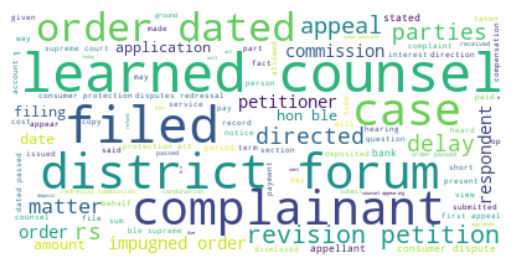

Cluster: 1 count: 4860


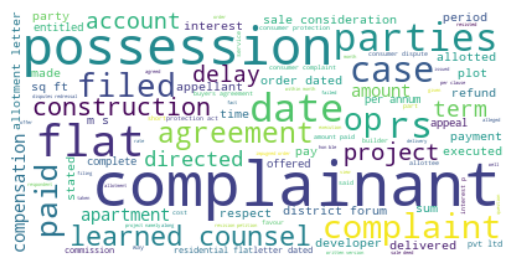

Cluster: 2 count: 5034


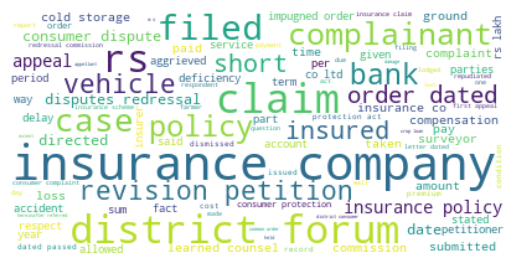

Cluster: 3 count: 3231


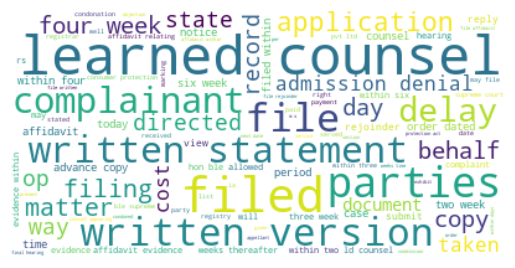

Cluster: 4 count: 1081


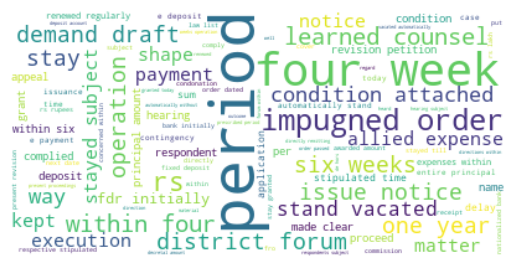

In [46]:
from wordcloud import WordCloud

result={'cluster':labels,'facts':facts_list2}
result=pd.DataFrame(result)
for k in range(0,true_k):
   s=result[result.cluster==k]
   text=s['facts'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split() if word not in ignore_words ])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {} count: {}'.format(k, counts[k]))

   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()